<a href="https://colab.research.google.com/github/prysykes/trevec/blob/main/keyframe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recall when we were unable to read some files and we thought the challenge was as a result of improper codec. It seems that some files in the lot has no file name, hence the loop was not able to decode it as a string after calling split(), this pipeline fixes that issue.

In [ ]:
# !pip uninstall katna -y
# ! pip install video-kf

In [ ]:
import torch, torchvision
import numpy as np
import pandas as pd
import sklearn
import random
import os
import cv2
import glob
import regex
import einops
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
# from tqdm import tqdm
from torchvision.transforms import v2



In [ ]:
from collections import Counter
from transformers import pipeline
import videokf as vf
print(f"Pytorch version: {torch.__version__}")
print(f"Is GPU available {torch.cuda.is_available()}")

Pytorch version: 2.2.1+cu121
Is GPU available True


In [ ]:
vid_keyframes = 'vid_keyframes'
trecvid_videos = 'trecvid_videos'
trecvid_files = os.listdir(trecvid_videos)
renamed_trecvid_videos  = 'renamed_trecvid_videos'
rename_vid_files = os.listdir(renamed_trecvid_videos)

print(os.path.isdir(vid_keyframes), os.path.isdir(trecvid_videos)),
print(os.path.isdir(renamed_trecvid_videos))


True True
True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import clip
model, preprocess = clip.load('ViT-B/32', device)

##### Steps:
1. Extract 3 key frames from the video file
2. Get the mean of the keyframes
3. project to lower dimension (50)
4. run through the baysian search to determine the the best parameters for HDBSCAN
5. Run this throught the existing pipeline

#### download zipped renamed videos

In [ ]:
# from google.colab import files
# files.download("/content/renamed_trec_vids.zip")

#### delete all files in a directory

In [ ]:
# for root, dirs, files in os.walk(vid_keyframes, topdown=False):
#   for file in files:
#     file_path = os.path.join(root, file)
#     try:
#       os.remove(file_path)
#     except Exception as e:
#       print(f"failed to delete file {e}")
#   for dir in dirs:
#     dir_path = os.path.join(root, dir)
#     try:
#       os.rmdir(dir_path)
#     except Exception as e:
#       print(f"unable to delete dir {e}")



## Extract Keyframes

In [ ]:
# to_delete = "vid_keyframes"
# print(os.path.isdir(to_delete))
# ! rm to_delete -r

In [ ]:
a_video_path = f"trecvid_videos/{trecvid_files[1]}"
print(os.path.splitext(a_video_path)[1])

.webm


In [ ]:
class ExtractKeyFrames:
  def __init__(self, parent_path):
    self.parent_path = parent_path

  def extract_key_frames(self):
    all_vid_files = os.listdir(self.parent_path)
    all_vid_files = sorted(all_vid_files, key=lambda x: int(x.split('.')[0]))
    for idx, vid in enumerate(all_vid_files):
      full_vid_path = os.path.join(self.parent_path, vid)
      file_name = os.path.splitext(full_vid_path)[0]
      file_name = file_name.split('/')[-1]
      try:
        os.mkdir(f"{vid_keyframes}/{file_name}")
        new_dir = os.path.join(vid_keyframes, file_name)
      except FileExistsError:
        new_dir = os.path.join(vid_keyframes, file_name)
        if len(os.listdir(new_dir))== 0:
          print("yesss", new_dir)
          vf.extract_keyframes(full_vid_path, output_dir_keyframes=new_dir)
      # print(new_dir, "newd")
      # # new_dir = os.path.join(vid_keyframes, )
      # # time.sleep(20)
      # print(os.path.isdir(new_dir))

      # vf.extract_keyframes(full_vid_path, output_dir_keyframes=new_dir)
      # if idx == 2:
      #   break

  def __call__(self):
    self.extract_key_frames()

In [ ]:
extract_keyframes = ExtractKeyFrames(renamed_trecvid_videos)
extract_keyframes()

yesss vid_keyframes/414
Iframes successfully extracted.
yesss vid_keyframes/955
Iframes successfully extracted.
yesss vid_keyframes/1137
Iframes successfully extracted.
yesss vid_keyframes/1168
Iframes successfully extracted.
yesss vid_keyframes/1271
Iframes successfully extracted.
yesss vid_keyframes/1431
Iframes successfully extracted.
yesss vid_keyframes/1728
Iframes successfully extracted.
yesss vid_keyframes/1819
Iframes successfully extracted.
yesss vid_keyframes/2401
Iframes successfully extracted.
yesss vid_keyframes/2483
Iframes successfully extracted.
yesss vid_keyframes/2561
Iframes successfully extracted.
yesss vid_keyframes/2569
Iframes successfully extracted.
yesss vid_keyframes/2947
Iframes successfully extracted.
yesss vid_keyframes/3053
Iframes successfully extracted.
yesss vid_keyframes/3075
Iframes successfully extracted.
yesss vid_keyframes/3124
Iframes successfully extracted.
yesss vid_keyframes/3295
Iframes successfully extracted.
yesss vid_keyframes/3398
Iframes 

#### Download and Review File

In [ ]:
# file_nm = "130.webm"
# dir_to_check = os.path.join(renamed_trecvid_videos, file_nm)
# from google.colab import files
# files.download(dir_to_check)
# cap = cv2.VideoCapture(dir_to_check)

# if (cap.isOpened()==False):
#   print("Error opening video stream or file")
# while (cap.isOpened()):
#   ret, frame = cap.read()
#   if ret == True:
#     print(np.mean(frame))
#     if cv2.waitKey(25) & 0xFF == ord('q'):
#       break

#   else:
#     break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
print(len(os.listdir(vid_keyframes)))

9000


In [ ]:
from PIL import Image

#### Check for all black or all white

In [ ]:
possible_black = []
possible_white = []
def check_for_black_or_white_bg(root_dir):
  for root, dirs, files in os.walk(root_dir, topdown=False):
    for file in files:
      # print(len(files))
      # read image
      full_path = os.path.join(root, file)
      full_dir_path = os.path.dirname(full_path)
      len_dir = len(os.listdir(full_dir_path))
      im = Image.open(full_path)

      if np.mean(im) <15:
        # check length of parent_dir
        if len_dir > 2:
          # print("len_dir", len_dir)
          possible_black.append(full_path)
          os.remove(full_path)
      elif np.mean(im) > 242:
        # print("greater",os.path.dirname(full_path))
        if len_dir > 2:
          # print("len_dir", len_dir)
          possible_white.append(full_path)
          os.remove(full_path)
check_for_black_or_white_bg(vid_keyframes)

In [ ]:
print(f"len possible_black {len(possible_black)} \n possible_white {len(possible_white)}")

len possible_black 101 
 possible_white 13


In [ ]:
a_possible_black = possible_black[20]
a_possible_white = possible_white[10]
print(a_possible_white)
print(os.listdir(f"{vid_keyframes}/7411"))

vid_keyframes/3398/513.jpg
['384.jpg', '0.jpg']


(<matplotlib.image.AxesImage at 0x7e8091376f80>, 196.63605251736112)

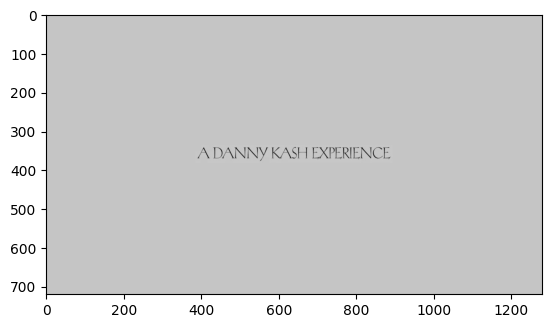

In [ ]:
# open image
im = Image.open("vid_keyframes/7411/384.jpg")
plt.imshow(im), np.mean(im)

In [ ]:
# a_file = trecvid_files[0]
# print(int(a_file.split('.')[0]))

15720


In [ ]:
import shutil

True


In [ ]:
# trecvid_files_ = os.listdir(trecvid_files)
# def sorting_key(x):
#   value = x.split('.')[0].strip()
#   print(f"value {value}")
#   return int(value)
# sorted_trecvid_files = sorted(trecvid_files, key=sorting_key)

sorted_renamed_vids = sorted(rename_vid_files, key=lambda x: int(x.split('.')[0]))
for idx, file in enumerate(sorted_renamed_vids):
  if idx == len(sorted_renamed_vids)-1:
    break
  if file == sorted_renamed_vids[idx+1]:
    print("found duplicate")
  if file.split('.')[0] == "":
    print("no name")
    break
  print(f"{idx}: {file}")
  if idx==2:
    break

# for idx, file in enumerate(trecvid_files):
#   try:
#     full_path = os.path.join(trecvid_videos, file)
#     new_full_path = os.path.join(renamed_trecvid_videos, f"{idx}.webm")
#     print(file, os.path.isfile(full_path))
#     shutil.copy(full_path, new_full_path)
#   except IsADirectoryError:
#     print(f"file {file}")


0: 0.webm
1: 1.webm
2: 2.webm


In [ ]:
print(len(os.listdir(renamed_trecvid_videos)))

9000


In [ ]:
empty_dir = []
for idx, item in enumerate(os.listdir(vid_keyframes)):
  full_dir_path = os.path.join(vid_keyframes, item)
  len_dir = len(os.listdir(full_dir_path))
  if len_dir == 0:
    print(f"{full_dir_path}: empy dir ")
    empty_dir.append(idx)
    # os.rmdir(full_dir_path)


In [ ]:
print(len(empty_dir)), print(empty_dir[0])

0


IndexError: list index out of range

In [ ]:
processed_key_frame_embeddings = "processed_key_frame_embeddings"
print(os.path.isdir(processed_key_frame_embeddings))

True


In [ ]:
def sort_fn(x):
  print(x)
  value = int(x.split('.')[0])
  return value

In [ ]:
class ProcessKeyFrameToEmbeddings:
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.count = 1
    self.keyframe_embeddings = []

  def get_frame_from_dir(self, root_dir):
    for idx, dir in enumerate(sorted(os.listdir(root_dir), key=lambda x: int(x.split('.')[0]))):
      full_dir_path = os.path.join(root_dir, dir)
      cur_vid_embeddings = []
      for file in os.listdir(full_dir_path):
        full_file_path = os.path.join(full_dir_path, file)
        img = Image.open(full_file_path)
        processed_img = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
          embeddings = model.encode_image(processed_img)
          cur_vid_embeddings.append(embeddings)
      # if len(cur_vid_embeddings) > 1:
      # print(len(cur_vid_embeddings))
      stacked_embeddings = torch.stack(cur_vid_embeddings, axis=0)
      average_embeddings = torch.mean(stacked_embeddings, axis=0).numpy(force=True)
      average_embeddings = np.squeeze(average_embeddings).tolist()
      cur_vid_embeddings = average_embeddings
      cur_load = {}
      cur_load['file_name'] = dir
      cur_load['embeddings'] = cur_vid_embeddings
      self.keyframe_embeddings.append(cur_load)
      # print(len(cur_vid_embeddings), cur_vid_embeddings[0].shape)


        # print(f"idx: {idx} \n file: {full_file_path}")
        # print(os.path.isfile(full_file_path))
      # if idx == 20:
      #   break
    return self.keyframe_embeddings



  def __call__(self):
    return self.get_frame_from_dir(self.root_dir)


In [ ]:
process_keyframe_to_embeddings = ProcessKeyFrameToEmbeddings(vid_keyframes)
keyframe_embeddings = process_keyframe_to_embeddings()

In [ ]:
print(len(keyframe_embeddings))

9000


In [ ]:
import csv

In [ ]:
field_names = ['file_name', 'embeddings']

with open('keyframes_embeddings.csv', 'w') as csv_file:
  writer = csv.DictWriter(csv_file, fieldnames=field_names)
  writer.writeheader()
  writer.writerows(keyframe_embeddings)

In [ ]:
# !zip -r /content/renamed_trec_vids.zip /content/renamed_trecvid_videos

In [ ]:
# from google.colab import files
# files.download("/content/renamed_trec_vids.zip")

In [ ]:
# from google.colab import files
# files.download(f"{renamed_trecvid_videos}/3277.webm")
# cap = cv2.VideoCapture(f"{renamed_trecvid_videos}/3277.webm")

# if (cap.isOpened()==False):
#   print("Error opening video stream or file")
# while (cap.isOpened()):
#   ret, frame = cap.read()
#   if ret == True:
#     print(np.mean(frame))
#     if cv2.waitKey(25) & 0xFF == ord('q'):
#       break

#   else:
#     break

# cap.release()
# cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from ast import literal_eval
df = pd.read_csv('keyframes_embeddings.csv', converters={'embeddings': literal_eval})

In [ ]:
df.head(10)

,file_name,embeddings
0,0,"[0.05316162109375, -0.219970703125, -0.3359375..."
1,1,"[-0.30517578125, 0.150634765625, 0.45336914062..."
2,2,"[-0.20654296875, 0.1566162109375, -0.057952880..."
3,3,"[-0.012451171875, 0.28955078125, -0.27734375, ..."
4,4,"[-0.4697265625, 0.13134765625, 0.0883178710937..."
5,5,"[0.0125732421875, 0.314697265625, 0.0860595703..."
6,6,"[0.1982421875, -0.161865234375, -0.3046875, 0...."
7,7,"[0.130615234375, 0.289306640625, 0.27514648437..."
8,8,"[0.0224609375, -0.059661865234375, 0.133422851..."
9,9,"[-0.390869140625, -0.103759765625, -0.39306640..."


## Dimensionality reduction

### Generate clusters function

In [ ]:
from hdbscan import HDBSCAN
import umap

In [ ]:
# explode the embedding column for each video
exploded_df = pd.DataFrame(df['embeddings'].to_list(), columns=[f'{i}' for i in range(len(df['embeddings'].max()))])

In [ ]:
exploded_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.053162,-0.219971,-0.335938,0.082520,-0.109619,0.173706,-0.207031,0.649902,0.112427,0.121826,...,-0.074341,0.138428,0.357178,0.046295,-0.154053,-0.226074,-0.292480,0.611328,-0.395752,-0.209229
1,-0.305176,0.150635,0.453369,-0.001328,0.227539,-0.130127,-0.006165,0.507812,-0.899414,-0.603027,...,-0.069214,0.054779,0.405273,-0.173706,-0.223022,0.466797,0.478760,0.553223,-0.256348,-0.009163
2,-0.206543,0.156616,-0.057953,0.104248,-0.160889,0.109131,0.001160,0.065796,0.086853,0.048401,...,-0.255859,-0.194336,-0.071655,-0.418457,0.246582,0.666016,-0.198242,0.110962,-0.055908,-0.352051
3,-0.012451,0.289551,-0.277344,0.061462,0.178345,0.076660,0.131470,0.314453,-0.129517,0.084839,...,-0.465820,-0.008972,0.478760,-0.138062,-0.215088,0.054321,-0.089355,1.135742,0.116272,-0.185547
4,-0.469727,0.131348,0.088318,0.281738,-0.330322,-0.245361,-0.053894,-0.167114,-0.212402,0.198853,...,-0.030350,-0.134155,0.182617,0.173828,-0.048950,-0.691406,0.011597,0.386230,0.066101,0.132202


In [ ]:
def generate_clusters(video_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state=None):
  """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
  """
  umap_embeddings = (umap.UMAP(
      n_neighbors=n_neighbors,
      n_components=n_components,
      metric="cosine",
      random_state=random_state).fit_transform(video_embeddings))
  hdbscan = HDBSCAN(min_cluster_size=min_cluster_size,
                    metric='euclidean',
                    cluster_selection_method='eom')
  clusters = hdbscan.fit(umap_embeddings)

  return clusters

### Bayesian Search for hyper parameters

In [ ]:
space = {
    "n_neighbors": range(5, 50),
    "n_components": range(5, 100),
    "min_cluster_size": range(20, 100),
    "random_state": 42
}
LABEL_LOWER = 50

In [ ]:
def score_clusters(clusters, prob_threshold=0.05):
  """
    args: clusters -> hdbscan clusters
    prob_threshold -> the min threshold of probability
    Returns the label count and the cost of a given cluster from
    hdbscan label count
  """
  cluster_labels = clusters.labels_
  label_count = len(np.unique(cluster_labels))
  total_num_clusters = len(cluster_labels)
  cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num_clusters)
  return label_count, cost

In [ ]:
from functools import partial
from hyperopt import fmin, space_eval, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params, video_embeddings, label_lower, label_upper):
  """
    Objective function for hyperopt to minimize the cost constraints
    on the number of clusters above out set threshold
  """
  clusters = generate_clusters(video_embeddings=video_embeddings,
                        n_neighbors=params['n_neighbors'],
                        n_components=params['n_components'],
                        min_cluster_size=params['min_cluster_size'],
                        random_state=params['random_state'])
  label_count, cost = score_clusters(clusters=clusters)
  if (label_count < label_lower) or (label_count > label_upper):
    penalty = 0.15
  else:
    penalty = 0
  loss = cost + penalty
  return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [ ]:
def baysian_search(video_embeddings, space, label_lower, label_upper, max_evals=100):
  trials = Trials()
  fmin_objective = partial(objective, video_embeddings=video_embeddings,
                           label_lower=label_lower, label_upper=label_upper)
  best = fmin(fmin_objective,
              space=space,
              algo=tpe.suggest,
              max_evals=max_evals,
              trials=trials)
  best_param = space_eval(space, best)

  best_clusters = generate_clusters(video_embeddings=video_embeddings,
                                    n_neighbors=best_param['n_neighbors'],
                                    n_components=best_param['n_components'],
                                    min_cluster_size=best_param['min_cluster_size'],
                                    random_state=best_param['random_state'])
  return best_param, best_clusters, trials

In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(2, 10)),
    "n_components": hp.choice('n_components', range(10, 50)),
    "min_cluster_size": hp.choice('min_cluster_size', range(10, 50)),
    "random_state": 42
}

label_lower = 30
label_upper = 50
max_evals = 30

In [ ]:
best_params, best_clusters_use, trials_use = baysian_search(exploded_df,
                                                            space=hspace,
                                                            label_lower=label_lower,
                                                            label_upper=label_upper,
                                                            max_evals=max_evals)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  3%|▎         | 1/30 [00:36<17:52, 36.98s/trial, best loss: 0.2021111111111111]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  7%|▋         | 2/30 [01:01<13:52, 29.74s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 10%|█         | 3/30 [01:22<11:29, 25.52s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 13%|█▎        | 4/30 [01:47<11:05, 25.58s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 17%|█▋        | 5/30 [02:04<09:16, 22.27s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|██        | 6/30 [02:28<09:11, 22.99s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 23%|██▎       | 7/30 [02:51<08:49, 23.04s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 27%|██▋       | 8/30 [03:11<08:05, 22.05s/trial, best loss: 0.1678888888888889]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 30%|███       | 9/30 [03:40<08:29, 24.27s/trial, best loss: 0.16755555555555554]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 33%|███▎      | 10/30 [04:10<08:39, 25.98s/trial, best loss: 0.16755555555555554]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 37%|███▋      | 11/30 [04:35<08:06, 25.61s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|████      | 12/30 [04:58<07:27, 24.87s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 43%|████▎     | 13/30 [05:23<07:04, 24.98s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 47%|████▋     | 14/30 [05:59<07:30, 28.15s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 50%|█████     | 15/30 [06:23<06:43, 26.88s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 53%|█████▎    | 16/30 [06:43<05:50, 25.02s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 57%|█████▋    | 17/30 [07:21<06:14, 28.82s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████    | 18/30 [07:46<05:31, 27.63s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 63%|██████▎   | 19/30 [08:10<04:53, 26.68s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 67%|██████▋   | 20/30 [08:44<04:47, 28.77s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 70%|███████   | 21/30 [09:05<03:57, 26.43s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 73%|███████▎  | 22/30 [09:27<03:21, 25.17s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 77%|███████▋  | 23/30 [10:03<03:17, 28.23s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|████████  | 24/30 [10:17<02:24, 24.03s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 83%|████████▎ | 25/30 [10:49<02:12, 26.52s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 87%|████████▋ | 26/30 [11:10<01:39, 24.95s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 90%|█████████ | 27/30 [11:46<01:24, 28.03s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 93%|█████████▎| 28/30 [12:13<00:55, 27.87s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 97%|█████████▋| 29/30 [12:33<00:25, 25.34s/trial, best loss: 0.15255555555555556]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|██████████| 30/30 [13:06<00:00, 26.22s/trial, best loss: 0.15255555555555556]


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
best_params

{'min_cluster_size': 48,
 'n_components': 32,
 'n_neighbors': 8,
 'random_state': 42}

In [ ]:
reducer = umap.UMAP(random_state=best_params['random_state'],
                    n_components=best_params['n_components'],
                    n_neighbors=best_params['n_neighbors'])

In [ ]:
vid_embeddings_reduced = reducer.fit_transform(exploded_df)

In [ ]:
vid_embeddings_reduced[0], vid_embeddings_reduced[0].size

(array([10.100827  , 10.494861  ,  8.787594  ,  6.9368553 ,  4.090923  ,
         5.611522  ,  0.33667165,  8.154818  ,  9.5820875 ,  2.5462003 ,
         0.07922447,  1.7207072 ,  0.8025008 ,  6.685718  ,  0.26262692,
         5.3735647 ,  4.54249   ,  4.4969397 ,  7.2720976 ,  8.444668  ,
         7.948932  ,  2.2742035 ,  1.6916343 ,  3.7246566 ,  5.367923  ,
         5.1814938 ,  9.055235  ,  6.7652698 ,  4.3044887 ,  3.8207562 ,
         4.2270503 ,  4.680367  ], dtype=float32),
 32)

In [ ]:
vid_embeddings_reduced.shape

(9000, 32)

In [ ]:
list_vid_embeddings_reduced  = vid_embeddings_reduced.tolist()
print(list_vid_embeddings_reduced[0])

[10.10082721710205, 10.494860649108887, 8.787593841552734, 6.936855316162109, 4.090922832489014, 5.611522197723389, 0.3366716504096985, 8.154817581176758, 9.582087516784668, 2.5462002754211426, 0.07922447472810745, 1.7207071781158447, 0.8025007843971252, 6.685718059539795, 0.26262691617012024, 5.373564720153809, 4.542490005493164, 4.496939659118652, 7.272097587585449, 8.44466781616211, 7.94893217086792, 2.2742035388946533, 1.6916342973709106, 3.724656581878662, 5.367922782897949, 5.181493759155273, 9.055234909057617, 6.765269756317139, 4.304488658905029, 3.820756196975708, 4.227050304412842, 4.6803669929504395]


In [ ]:
reduced_df = df.copy()
reduced_df = reduced_df.drop('embeddings', axis=1)

In [ ]:
reduced_df['embeddings'] = list_vid_embeddings_reduced

In [ ]:
len(reduced_df['embeddings'][0])
reduced_df.head(5)

,file_name,embeddings
0,0,"[10.10082721710205, 10.494860649108887, 8.7875..."
1,1,"[10.022843360900879, 10.162393569946289, 8.760..."
2,2,"[9.978711128234863, 10.174576759338379, 8.3288..."
3,3,"[10.091052055358887, 10.736542701721191, 8.918..."
4,4,"[10.067634582519531, 10.121840476989746, 9.117..."


In [ ]:
# explode the embedding column for each video
exploded_reduced_df = pd.DataFrame(reduced_df['embeddings'].to_list(), columns=[f'{i}' for i in range(len(reduced_df['embeddings'].max()))])

In [ ]:
exploded_reduced_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,10.100827,10.494861,8.787594,6.936855,4.090923,5.611522,0.336672,8.154818,9.582088,2.546200,...,1.691634,3.724657,5.367923,5.181494,9.055235,6.765270,4.304489,3.820756,4.227050,4.680367
1,10.022843,10.162394,8.760173,7.466994,5.642733,5.818882,0.393602,8.188601,9.513680,2.430658,...,1.656960,3.570067,5.071487,5.089424,8.892501,6.935550,4.345854,4.013374,3.928400,4.844877
2,9.978711,10.174577,8.328827,5.507035,7.045728,6.258943,0.147573,8.159242,9.757702,2.464399,...,1.590652,3.691520,5.000958,5.101514,8.941860,6.900243,4.333203,3.431350,3.981940,5.172534
3,10.091052,10.736543,8.918793,7.360313,4.490848,5.636734,0.352388,8.191058,9.522043,2.631343,...,1.771852,3.962250,5.335017,5.098690,8.998927,7.226882,4.317399,4.028358,4.146372,5.037048
4,10.067635,10.121840,9.117106,9.503753,3.934457,5.311082,0.588104,7.992404,9.174615,2.555104,...,1.971125,2.887606,5.012866,5.031002,8.937718,6.922265,4.294809,4.457954,4.167801,3.969168


In [ ]:
reduced_df.head(5)

,file_name,embeddings
0,0,"[10.10082721710205, 10.494860649108887, 8.7875..."
1,1,"[10.022843360900879, 10.162393569946289, 8.760..."
2,2,"[9.978711128234863, 10.174576759338379, 8.3288..."
3,3,"[10.091052055358887, 10.736542701721191, 8.918..."
4,4,"[10.067634582519531, 10.121840476989746, 9.117..."


In [ ]:
hdbscan = HDBSCAN(4) # 3 was good

In [ ]:
clusters = hdbscan.fit_predict(exploded_reduced_df)
unique_cluster_ids = np.unique(clusters)
len(unique_cluster_ids)

365

### reassign clusters

In [ ]:
cp_reduced_df = reduced_df.copy()
cp_reduced_df['cluster_id'] = clusters

In [ ]:
print(len(cp_reduced_df[cp_reduced_df['cluster_id']==-1]))

3773


In [ ]:
cp_reduced_df[cp_reduced_df['cluster_id']==179].sample(5)

,file_name,embeddings,cluster_id
5689,5689,"[10.025922775268555, 9.482206344604492, 8.9417...",179
1524,1524,"[10.023029327392578, 9.452322959899902, 8.9223...",179
6321,6321,"[10.03157901763916, 9.667868614196777, 8.95077...",179
7326,7327,"[10.025217056274414, 9.55471420288086, 8.94887...",179
5997,5997,"[10.028133392333984, 9.561931610107422, 8.9442...",179


In [ ]:
unique_cluster_ids = list(cp_reduced_df['cluster_id'].unique())
unique_cluster_ids
# print(unique_cluster_ids)
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    # if cluster_size < 100:
    #   print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    # # # if cluster_size > 200:
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(cp_reduced_df, unique_cluster_ids)

Cluster ID: 357 
. Cluster Size: 25
Cluster ID: 121 
. Cluster Size: 13
Cluster ID: 78 
. Cluster Size: 17
Cluster ID: -1 
. Cluster Size: 3773
Cluster ID: 172 
. Cluster Size: 13
Cluster ID: 363 
. Cluster Size: 158
Cluster ID: 55 
. Cluster Size: 5
Cluster ID: 17 
. Cluster Size: 8
Cluster ID: 224 
. Cluster Size: 49
Cluster ID: 290 
. Cluster Size: 29
Cluster ID: 243 
. Cluster Size: 4
Cluster ID: 91 
. Cluster Size: 7
Cluster ID: 276 
. Cluster Size: 27
Cluster ID: 311 
. Cluster Size: 8
Cluster ID: 40 
. Cluster Size: 6
Cluster ID: 203 
. Cluster Size: 33
Cluster ID: 157 
. Cluster Size: 7
Cluster ID: 49 
. Cluster Size: 56
Cluster ID: 215 
. Cluster Size: 12
Cluster ID: 24 
. Cluster Size: 18
Cluster ID: 305 
. Cluster Size: 95
Cluster ID: 144 
. Cluster Size: 9
Cluster ID: 265 
. Cluster Size: 148
Cluster ID: 112 
. Cluster Size: 19
Cluster ID: 302 
. Cluster Size: 6
Cluster ID: 286 
. Cluster Size: 49
Cluster ID: 186 
. Cluster Size: 35
Cluster ID: 300 
. Cluster Size: 24
Clust

In [ ]:
len(unique_cluster_ids)

365

In [ ]:
df.head(5)

,file_name,embeddings
0,0,"[0.05316162109375, -0.219970703125, -0.3359375..."
1,1,"[-0.30517578125, 0.150634765625, 0.45336914062..."
2,2,"[-0.20654296875, 0.1566162109375, -0.057952880..."
3,3,"[-0.012451171875, 0.28955078125, -0.27734375, ..."
4,4,"[-0.4697265625, 0.13134765625, 0.0883178710937..."


In [ ]:
class ReclusterNoise:
  def __init__(self, vid_embeddings_reduced, min_cluster_size, recluster_rounds):
    self.vid_embeddings_reduced = vid_embeddings_reduced
    self.min_cluster_size = min_cluster_size
    self.recluster_rounds = recluster_rounds
    self.final_clusters = pd.DataFrame()
    self.noise = pd.DataFrame()
    self.start = False
    self.count = 1

  def exploded_df(self, dataframe):
    print(f"start exploding df {dataframe.shape}")
    new_embedding_df = pd.DataFrame(dataframe['embeddings'].to_list(), columns=[f'{i}' for i in range(len(dataframe['embeddings'].max()))])
    print(f"done exploding df {dataframe.shape}")
    return new_embedding_df

  def reassign_cluster_ids(self, cluster_ids):
    print("reassigning cluster_ids")
    new_cluster_ids = [f'{self.count}-{idx}' for idx in cluster_ids]
    #update count
    self.count += 1
    return new_cluster_ids

  def update_finaldf_and_noise(self, unique_cluster_ids, dataframe):
    print("updating finaldf and noise")
    cur_final_clusters = pd.DataFrame()
    cur_noise = pd.DataFrame()
    for idx in unique_cluster_ids:
      if idx != -1:
        cur_good_cluster = dataframe[dataframe['cluster_id']==idx]
        cur_final_clusters = pd.concat([cur_final_clusters, cur_good_cluster], ignore_index=True)
      else:
        cur_noise = dataframe[dataframe['cluster_id']==idx]
    if not self.start:
      return cur_noise, cur_final_clusters
    else:
      # reassign cur_final_clusters
      cluster_ids =  cur_final_clusters['cluster_id']
      new_cluster_ids = self.reassign_cluster_ids(cluster_ids=cluster_ids)
      cur_final_clusters = cur_final_clusters.drop('cluster_id', axis=1)
      cur_final_clusters['cluster_id'] = new_cluster_ids
      return cur_noise, cur_final_clusters





  def cluster_df(self, dataframe, exploded_df):
    print("clustering df")
    hdbscan = HDBSCAN(self.min_cluster_size)
    clusters = hdbscan.fit_predict(exploded_df)
    # new_cluster_ids = self.reassign_cluster_ids(clusters)
    unique_cluster_ids = np.unique(clusters)
    dataframe['cluster_id'] = clusters
    # seperate -1 (noise) clusters
    cur_noise, cur_final_clusters = self.update_finaldf_and_noise(unique_cluster_ids, dataframe)
    self.noise = cur_noise
    self.final_clusters = pd.concat([self.final_clusters, cur_final_clusters], ignore_index=True)
    return self.final_clusters, self.noise
    # reassign noise and use for next cluster round



  def __call__(self):
    while True:
      if not self.start:
        exploded_df = self.exploded_df(self.vid_embeddings_reduced)
        self.final_clusters, self.noise = self.cluster_df(self.vid_embeddings_reduced, exploded_df)
        self.start = True
      else:
        while self.recluster_rounds != 0 and not self.noise.empty:
          exploded_noise = self.exploded_df(self.noise)
          self.final_clusters, self.noise = self.cluster_df(self.noise, exploded_noise)

          self.recluster_rounds -= 1
        break
    # self.vid_embeddings_reduced = self.vid_embeddings_reduced.drop('embeddings', axis=1)
    # self.vid_embeddings_reduced['embeddings'] = new_embedding_df

    return self.final_clusters, self.noise

In [ ]:
recluster_noise = ReclusterNoise(vid_embeddings_reduced=reduced_df, min_cluster_size=4, recluster_rounds=2)

In [ ]:
final_clusters, noise = recluster_noise()

start exploding df (9000, 3)
done exploding df (9000, 3)
clustering df
updating finaldf and noise
start exploding df (3773, 3)
done exploding df (3773, 3)
clustering df
updating finaldf and noise
reassigning cluster_ids


<ipython-input-352-e212b250195e>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cluster_id'] = clusters


In [ ]:
len(final_clusters['file_name'])

9000

In [ ]:
unique_cluster_ids = list(final_clusters['cluster_id'].unique())
unique_cluster_ids
# print(unique_cluster_ids)
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    # if cluster_size < 100:
    #   print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    # # # if cluster_size > 200:
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(final_clusters, unique_cluster_ids)

Cluster ID: 0 
. Cluster Size: 17
Cluster ID: 1 
. Cluster Size: 17
Cluster ID: 2 
. Cluster Size: 8
Cluster ID: 3 
. Cluster Size: 17
Cluster ID: 4 
. Cluster Size: 6
Cluster ID: 5 
. Cluster Size: 13
Cluster ID: 6 
. Cluster Size: 5
Cluster ID: 7 
. Cluster Size: 11
Cluster ID: 8 
. Cluster Size: 35
Cluster ID: 9 
. Cluster Size: 6
Cluster ID: 10 
. Cluster Size: 31
Cluster ID: 11 
. Cluster Size: 10
Cluster ID: 12 
. Cluster Size: 9
Cluster ID: 13 
. Cluster Size: 14
Cluster ID: 14 
. Cluster Size: 6
Cluster ID: 15 
. Cluster Size: 11
Cluster ID: 16 
. Cluster Size: 7
Cluster ID: 17 
. Cluster Size: 8
Cluster ID: 18 
. Cluster Size: 8
Cluster ID: 19 
. Cluster Size: 8
Cluster ID: 20 
. Cluster Size: 6
Cluster ID: 21 
. Cluster Size: 6
Cluster ID: 22 
. Cluster Size: 21
Cluster ID: 23 
. Cluster Size: 10
Cluster ID: 24 
. Cluster Size: 18
Cluster ID: 25 
. Cluster Size: 8
Cluster ID: 26 
. Cluster Size: 15
Cluster ID: 27 
. Cluster Size: 9
Cluster ID: 28 
. Cluster Size: 7
Cluster ID

In [ ]:
# unique_cluster_ids

In [ ]:
final_clusters[final_clusters['cluster_id']=="1-1"].sample(5)

,file_name,embeddings,cluster_id
5253,3562,"[9.984458923339844, 7.129650592803955, 8.33250...",1-1
5252,2585,"[9.980534553527832, 7.348260402679443, 8.32483...",1-1
5254,7603,"[9.987676620483398, 7.530883312225342, 8.33607...",1-1
5250,1727,"[10.000479698181152, 7.450361728668213, 8.3768...",1-1
5255,7948,"[9.992136001586914, 7.7119526863098145, 8.3758...",1-1


In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size,
               upper_min_cluster_size, lower_limit,
               recluster_limit,
               recluster_min_cluster_size, lower_cap_for_recluster, reclustering_count):
    self.original_df = original_df
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.default_upper_min_cluster_size = upper_min_cluster_size
    self.min_cluster_size = None
    self.lower_limit = lower_limit
    self.recluster_limit = recluster_limit
    self.current_noise = None
    self.final_clusters = pd.DataFrame()
    self.large_container = [] #{cluster_id: cluster} the
    self.count = 1
    self.reclustering_count = reclustering_count
    self.recluster_min_cluster_size = recluster_min_cluster_size
    self.recluster_min_cluster_size_default = recluster_min_cluster_size
    self.lower_cap_for_recluster = lower_cap_for_recluster
    # self.reclustering_limit = reclustering_limit
    self.start = False
    self.run = True

  def explode_embeddings(self, embeddings_df, caller=""):
    print(f"caller {caller} embeddings_df.shape", embeddings_df.shape)
    exploded_df = pd.DataFrame(embeddings_df['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(embeddings_df['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def reassign_cluster_idx(self, count, embeddings_df, recluster_large=False):
    print("reassigning cluster ids")
    # extract embeddings_df cluster_ids
    cluster_ids = embeddings_df['cluster_id']
    # update current cluster_ids
    if not recluster_large:
      new_cluster_ids = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    else:
      new_cluster_ids = []
      for idx in list(cluster_ids):
        updated_id = f"{count}{self.reclustering_count}_{idx}"
        new_cluster_ids.append(updated_id)
      new_cluster_ids = np.array(new_cluster_ids)
      # new_cluster_ids = np.array([f"{32}_{idx}" for idx in list(cluster_ids)])
    # drop old cluster_idx
    embeddings_df = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df['cluster_id'] = new_cluster_ids
    return embeddings_df

  def compare_to_lower_limit(self, count, unique_cluster_ids, dataframe, large_container, caller=""):
    print(f"caller {caller}: Comparing cluster to lower limit")
    for idx in unique_cluster_ids:
      cluster_df = dataframe[dataframe['cluster_id']== idx]
      if len(cluster_df.index) < self.lower_limit:
        if caller != "cluster_embeddings":
          updated_cluster = self.reassign_cluster_idx(count, cluster_df, recluster_large=True)
        updated_cluster = self.reassign_cluster_idx(count, cluster_df)
        self.final_clusters = pd.concat([self.final_clusters, updated_cluster], ignore_index=True)
        count += 1
      else:
        large_container.insert(0, cluster_df)

  def cluster_large_clusters(self, count, dataframe, large_container, reclustering_count):
    print("clustering large clusters")
    if reclustering_count % 10 == 0:
      #for every 10 reclusters, reduce min_cluster_size
      if self.recluster_min_cluster_size == self.lower_cap_for_recluster:
        self.recluster_min_cluster_size = self.recluster_min_cluster_size_default
      else:
        self.recluster_min_cluster_size -= 1
    hdbscan = HDBSCAN(self.recluster_min_cluster_size)
    exploded_df = self.explode_embeddings(dataframe, caller="cluster_large_clusters")
    cluster_ids = hdbscan.fit_predict(exploded_df)
    dataframe = dataframe.drop('cluster_id', axis=1)
    dataframe['cluster_id'] = cluster_ids
    unique_cluster_ids = np.unique(cluster_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, dataframe, large_container, caller="cluster_large_clusters")


  def recluster_large_clusters(self, count, large_container):
    print("reclustering large clusters")
    while large_container:
      if self.reclustering_count == 0:#self.reclustering_limit:
        break

      print("len(large_clusters)", len(large_container), "type", type(large_container))
      dataframe = large_container.pop()
      self.cluster_large_clusters(count, dataframe, large_container, self.reclustering_count)
      self.reclustering_count -= 1
    return large_container



  def cluster_embeddings(self, count, exploded_embeddings, embeddings_df, large_clusters=False):
    print("clustering embeddings")
    # run optimization here
    hdbscan = HDBSCAN(self.upper_min_cluster_size)
    cur_cluster_ids = hdbscan.fit_predict(exploded_embeddings)
    embeddings_df_droped = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df_droped['cluster_id'] = cur_cluster_ids
    # extract noise and set self.current_noise
    cur_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] == -1]
    # self.current_noise = cur_noise
    # extract other clusters
    not_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] != -1]
    not_noise_ids = not_noise['cluster_id']
    unique_cluster_ids = np.unique(not_noise_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, not_noise, self.large_container, caller="cluster_embeddings")

    return cur_noise

  def __call__(self):
    while True:
      while self.run:
        if not self.start:
          exploded_embeddings = self.explode_embeddings(self.original_df)
          self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.original_df)
          self.start = True
          self.count += 1
        else:
          # print("before: len(self.current_noise.index)", len(self.current_noise.index))
          while len(self.current_noise.index) > self.lower_limit:

            if self.upper_min_cluster_size < self.lower_min_cluster_size:
              # print("self.upper_min_cluster_size")
              # check if noise is empty dataframe
              if self.current_noise.empty():
                break
              else:
                # update final_cluster with noise and break out of this loop
                self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
                break
            else:
              # reduce the min_cluster_size until its == to
              self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
              # explode current noise
              exploded_embeddings = self.explode_embeddings(self.current_noise)
              # cluster current noise
              self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.current_noise)
              self.count += 1
          # add remaning noise to final cluster if any
          self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
          self.run = False
      break

    # reset upper min cluster size
    self.upper_min_cluster_size = self.default_upper_min_cluster_size
    self.recluster_large_clusters(self.count, self.large_container)
    return self.final_clusters, self.large_container


In [ ]:
recluster =  Recluster(reduced_df, lower_min_cluster_size=3,
                       upper_min_cluster_size=6, lower_limit=150, recluster_limit=200,
                       recluster_min_cluster_size=4, lower_cap_for_recluster=2, reclustering_count=100)

In [ ]:
final_clusters, large_clusters = recluster()

caller  embeddings_df.shape (9000, 3)
explode_rem done...
clustering embeddings
caller cluster_embeddings: Comparing cluster to lower limit
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster ids
reassigning cluster 

In [ ]:
print(len(final_clusters.index))

9000


In [ ]:
unique_cluster_ids = list(final_clusters['cluster_id'].unique())
unique_cluster_ids
# print(unique_cluster_ids)
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    # if cluster_size < 100:
    #   print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    # # # if cluster_size > 200:
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(final_clusters, unique_cluster_ids)

Cluster ID: 1_0 
. Cluster Size: 17
Cluster ID: 2_1 
. Cluster Size: 17
Cluster ID: 3_2 
. Cluster Size: 17
Cluster ID: 4_3 
. Cluster Size: 8
Cluster ID: 5_4 
. Cluster Size: 24
Cluster ID: 6_5 
. Cluster Size: 13
Cluster ID: 7_6 
. Cluster Size: 16
Cluster ID: 8_7 
. Cluster Size: 35
Cluster ID: 9_8 
. Cluster Size: 36
Cluster ID: 10_9 
. Cluster Size: 10
Cluster ID: 11_10 
. Cluster Size: 18
Cluster ID: 12_11 
. Cluster Size: 9
Cluster ID: 13_12 
. Cluster Size: 31
Cluster ID: 14_13 
. Cluster Size: 9
Cluster ID: 15_14 
. Cluster Size: 14
Cluster ID: 16_15 
. Cluster Size: 8
Cluster ID: 17_16 
. Cluster Size: 10
Cluster ID: 18_17 
. Cluster Size: 18
Cluster ID: 19_18 
. Cluster Size: 7
Cluster ID: 20_19 
. Cluster Size: 18
Cluster ID: 21_20 
. Cluster Size: 19
Cluster ID: 22_21 
. Cluster Size: 107
Cluster ID: 23_22 
. Cluster Size: 89
Cluster ID: 24_23 
. Cluster Size: 11
Cluster ID: 25_24 
. Cluster Size: 9
Cluster ID: 26_25 
. Cluster Size: 8
Cluster ID: 27_26 
. Cluster Size: 7


In [ ]:
final_clusters[final_clusters['cluster_id']=='51_50'].sample(5)

,file_name,embeddings,cluster_id
896,7943,"[10.039416313171387, 9.965971946716309, 8.6064...",51_50
882,2993,"[10.033419609069824, 9.989296913146973, 8.5963...",51_50
878,328,"[10.03886890411377, 10.017712593078613, 8.6118...",51_50
884,3551,"[10.035054206848145, 10.007401466369629, 8.596...",51_50
889,5391,"[10.039154052734375, 9.87504768371582, 8.59092...",51_50
